In [2]:
import numpy as np
%config Completer.use_jedi = False

import sklearn
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt#
from scipy.stats import pearsonr

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem

import glob
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
all_ligands = sorted(glob.glob('/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/sdf/ligands/*.sdf'))
all_pharmacophores = sorted(glob.glob('/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/sdf/pharmacophores/*.sdf'))

In [4]:
all_ligand_mols = [Chem.MolFromMolFile(x) for x in all_ligands]
all_pharm_mols = [Chem.MolFromMolFile(x) for x in all_pharmacophores]

In [5]:
print(Chem.MolToMolBlock(all_pharm_mols[1]))


     RDKit          3D

  7  0  0  0  0  0  0  0  0  0999 V2000
    8.2914    1.1069    4.8972 N   0  0  0  0  0  0  0  0  0  0  0  0
    5.7529    0.2681   -1.8452 N   0  0  0  0  0  0  0  0  0  0  0  0
    7.9934   -6.8662    5.7167 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6492    7.0522    3.5541 O   0  0  0  0  0  0  0  0  0  0  0  0
   10.1686    4.4010   -5.2345 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9428   -3.7984    5.0409 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.0119   -5.9356    1.6974 O   0  0  0  0  0  0  0  0  0  0  0  0
M  END



In [6]:
print(Chem.MolToMolBlock(all_pharm_mols[2]))


     RDKit          3D

  7  0  0  0  0  0  0  0  0  0999 V2000
    8.2914    1.1069    4.8972 N   0  0  0  0  0  0  0  0  0  0  0  0
    5.8444    0.4767   -3.3563 N   0  0  0  0  0  0  0  0  0  0  0  0
    7.9934   -6.8662    5.7167 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6492    7.0522    3.5541 O   0  0  0  0  0  0  0  0  0  0  0  0
   10.1686    4.4010   -5.2345 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9428   -3.7984    5.0409 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.0119   -5.9356    1.6974 O   0  0  0  0  0  0  0  0  0  0  0  0
M  END



In [7]:
for idx in range(all_pharm_mols[0].GetNumAtoms()):
    
    
    if np.linalg.norm(np.array(all_pharm_mols[0].GetConformer().GetAtomPosition(idx)) - np.array(all_pharm_mols[1].GetConformer().GetAtomPosition(idx))) > 0.01:
        moving_idx = idx
    
    

In [8]:
moving_idx

1

In [9]:
print(Chem.MolToMolBlock(all_ligand_mols[0]))


     RDKit          3D

 20 20  0  0  0  0  0  0  0  0999 V2000
   -4.9400   -1.9289    1.3128 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.4761   -0.6872    0.7991 O   0  0  0  0  0  0  0  0  0  0  0  0
   -3.4423   -0.6986   -0.2313 C   0  0  2  0  0  0  0  0  0  0  0  0
   -3.9568   -1.4330   -1.4671 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0297   -1.1423    0.2473 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7401    0.3334    0.6280 C   0  0  1  0  0  0  0  0  0  0  0  0
   -0.3372    0.8372    0.4429 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1589    2.2865    0.4959 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7561   -0.0117    0.6030 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6721   -1.1845    0.9567 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.9711    0.5657    0.3404 N   0  0  0  0  0  0  0  0  0  0  0  0
    3.1838   -0.2294    0.3953 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.3776    0.5880   -0.1139 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.1995    1.6969   -0

In [10]:
ligand_key_atom_coords = np.array(all_ligand_mols[0].GetConformer().GetAtomPosition(14))

In [11]:
distance_to_pharm = [np.linalg.norm(ligand_key_atom_coords - np.array(x.GetConformer().GetAtomPosition(moving_idx))) for x in all_pharm_mols] 

In [12]:
ligand_key_atom_coords

array([5.641e+00, 1.320e-02, 1.700e-03])

In [13]:
PLEC_cutoffs = ['25', '3', '35', '4', '45', '5', '55', '6']
PLEC_cutoffs = ['4']

key_atom_rankings = {}

for pc in PLEC_cutoffs:
    
    key_atom_rankings[pc] = []
    
    dataframes = sorted(glob.glob(f'/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_{pc}/*.csv'))
    
    for dataframe in dataframes:
        
        
        print(dataframe)
        
        df = pd.read_csv(dataframe, sep = ' ')
        #print(df.head())       
            
        for idx, row in df.iterrows():
            atom_coords = np.array([row['x'], row['y'], row['z']])
            if np.linalg.norm(atom_coords - ligand_key_atom_coords) < 0.05:
                ranking = idx + 1
                
        print(ranking)
        key_atom_rankings[pc].append(ranking)
    


/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df0.csv
1
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df1.csv
1
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df10.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df11.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df12.csv
1
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df13.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df14.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df15.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df16.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df17.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df18.csv
7
/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df19.csv
7
/data/

In [14]:
PLEC_cutoffs = ['25', '3', '35', '4', '45', '5', '55', '6']


key_atom_rankings = {}

for pc in PLEC_cutoffs:
    
    distances = []
    key_atom_rankings[pc] = []
    
    
    for idx in range(50):
        dataframe = f'/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_{pc}/df{idx}.csv'
    
        pharm_mol = Chem.MolFromMolFile(sorted(glob.glob(f'/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/sdf/pharmacophores/pharm*.sdf'))[idx])
        distance_to_pharm = np.linalg.norm(ligand_key_atom_coords - np.array(pharm_mol.GetConformer().GetAtomPosition(moving_idx)))
        distances.append(distance_to_pharm)
        
        
        
        df = pd.read_csv(dataframe, sep = ' ')
        #print(df.head())       
            
        for idx, row in df.iterrows():
            atom_coords = np.array([row['x'], row['y'], row['z']])
            if np.linalg.norm(atom_coords - ligand_key_atom_coords) < 0.05:
                ranking = idx + 1
                
        key_atom_rankings[pc].append(ranking)
    


In [15]:
len(key_atom_rankings['4'])

50

In [16]:
dataframes

['/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df0.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df1.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df10.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df11.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df12.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df13.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df14.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df15.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df16.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df17.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attributions_4/df18.csv',
 '/data/hookbill/hadfield/syntheticVS/example_to_perturb_2/attribut

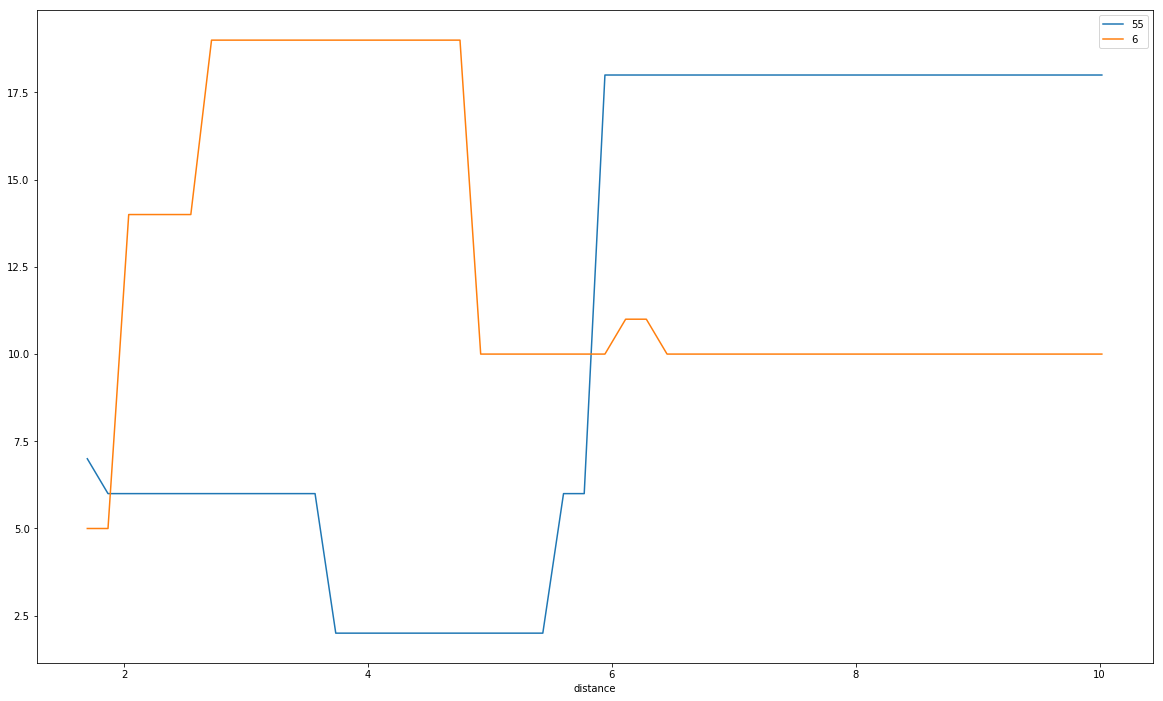

In [17]:
key_atom_rankings_df = pd.DataFrame(key_atom_rankings)
key_atom_rankings_df['distance'] = distances
key_atom_rankings_df.sort_values('distance', ascending = True, inplace=True)
key_atom_rankings_df.set_index('distance', inplace = True)
#key_atom_rankings_df[['4', '45', '5']].plot(figsize = (20, 12))
key_atom_rankings_df[['55', '6']].plot(figsize = (20, 12))

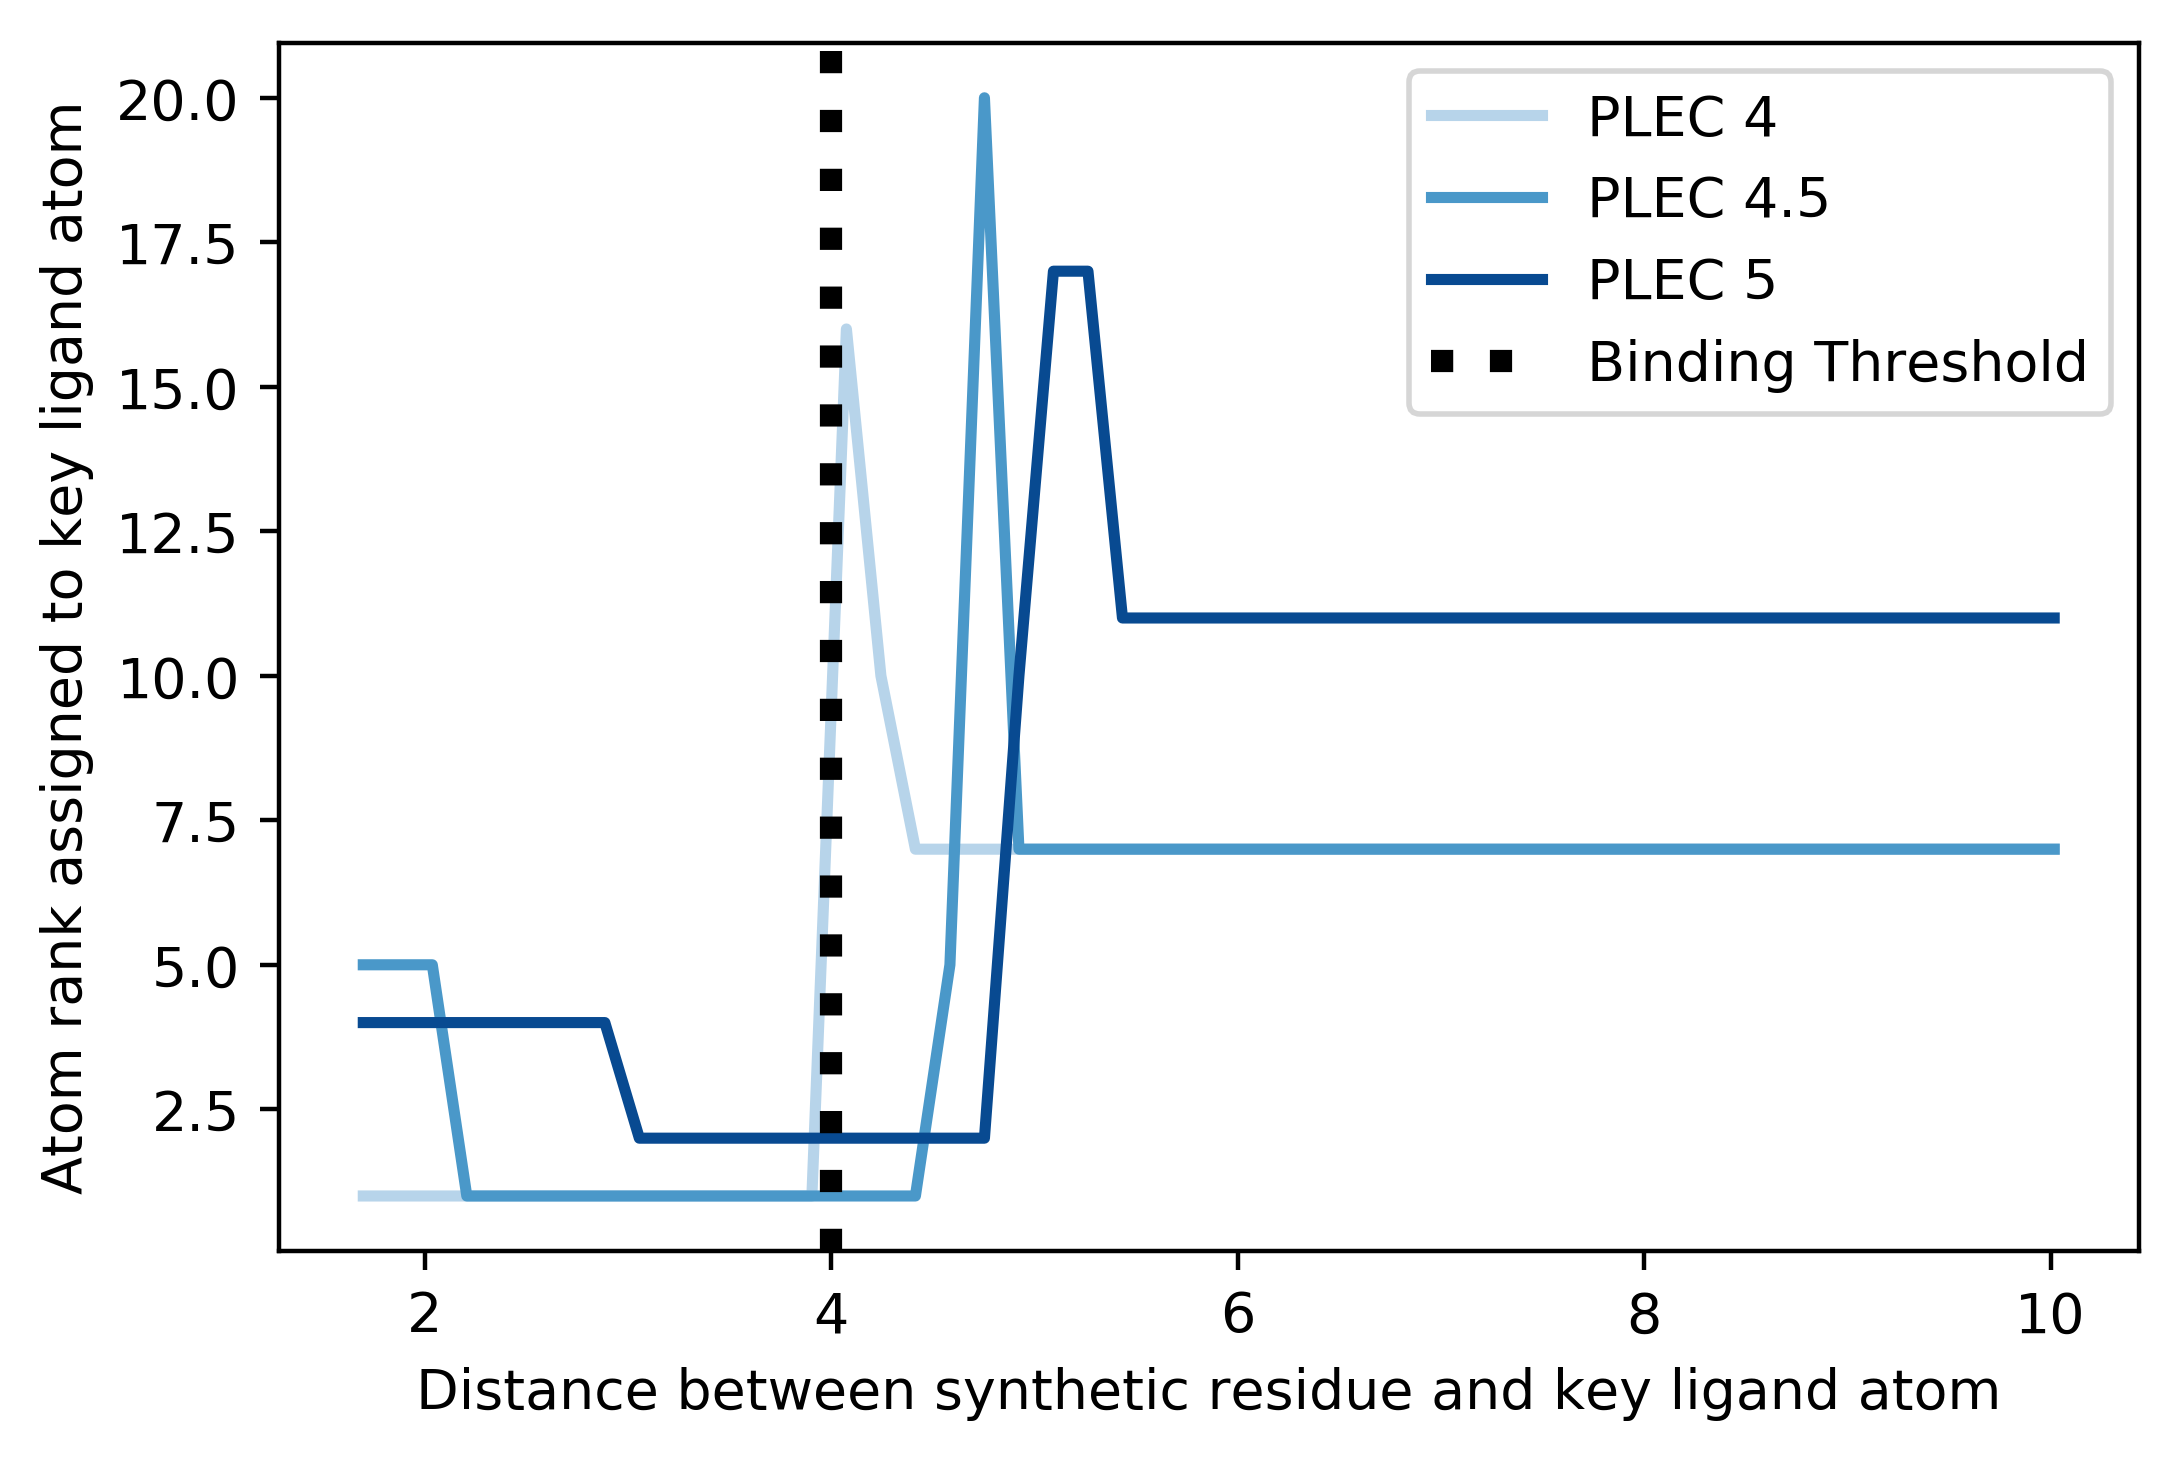

In [26]:
import matplotlib as mpl
c = np.arange(1, 12)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

plt.figure(dpi=400)
plt.plot(np.array(key_atom_rankings_df.index), key_atom_rankings_df['4'], label = 'PLEC 4', linewidth = 2, color=cmap.to_rgba(4))
plt.plot(np.array(key_atom_rankings_df.index), key_atom_rankings_df['45'], label = 'PLEC 4.5', linewidth = 2, color=cmap.to_rgba(7))
plt.plot(np.array(key_atom_rankings_df.index), key_atom_rankings_df['5'], label = 'PLEC 5', linewidth = 2, color=cmap.to_rgba(10))
plt.xlabel('Distance between synthetic residue and key ligand atom')
plt.ylabel('Atom rank assigned to key ligand atom')
plt.axvline(x=4, ls = ':', lw=4, label = 'Binding Threshold', color = 'black')
plt.legend()
plt.savefig('/data/hookbill/hadfield/syntheticVS/figures_for_paper/case_study_results.png')
plt.show()

In [19]:
key_atom_rankings_df

,25,3,35,4,45,5,55,6
distance,,,,,,,,
1.697974,20,2,2,1,5,4,7,5
1.867762,20,2,2,1,5,4,6,5
2.037558,2,2,2,1,5,4,6,14
2.207360,2,2,2,1,1,4,6,14
2.377162,2,2,2,1,1,4,6,14
2.546950,2,2,3,1,1,4,6,14
2.716746,4,2,3,1,1,4,6,19
2.886548,11,2,3,1,1,4,6,19
3.056350,13,1,3,1,1,2,6,19


In [90]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
Chem.MolFromMolFile('/homes/hadfield/Downloads/')